In [21]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import dill
from datetime import datetime
from copy import deepcopy
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import lovely_tensors as lt

import csng
from csng.CNN_Decoder import CNN_Decoder
from csng.utils import plot_comparison, standardize, normalize, get_mean_and_std, count_parameters
from csng.losses import SSIMLoss, MSELossWithCrop

from data import (
    prepare_v1_dataloaders,
    SyntheticDataset,
    BatchPatchesDataLoader,
    MixedBatchLoader,
    PerSampleStoredDataset,
)

lt.monkey_patch()

DATA_PATH = os.path.join(os.environ["DATA_PATH"], "cat_V1_spiking_model", "50K_single_trial_dataset")
print(f"{DATA_PATH=}")

DATA_PATH='/media/jsobotka/ext_ssd/csng_data/cat_V1_spiking_model/50K_single_trial_dataset'


In [2]:
config = {
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
    },
    "stim_crop_win": (slice(15, 35), slice(15, 35)),
    "only_v1_data_eval": True,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
}

print(f"... Running on {config['device']} ...")

... Running on cuda ...


In [3]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

In [4]:
if config["stim_crop_win"] is not None:
    crop_stim = lambda x: x[..., config["stim_crop_win"][0], config["stim_crop_win"][1]]
else:
    crop_stim = lambda x: x

## Data

In [5]:
dataloaders = dict()

### V1 dataset (spiking model of cat V1)

In [6]:
config["data"]["v1_data"] = {
    "train_path": os.path.join(DATA_PATH, "datasets", "train"),
    "val_path": os.path.join(DATA_PATH, "datasets", "val"),
    "test_path": os.path.join(DATA_PATH, "datasets", "test"),
    "image_size": [50, 50],
    "crop": False,
    "batch_size": 64,
    "stim_keys": ("stim",),
    "resp_keys": ("exc_resp", "inh_resp"),
    "return_coords": True,
    "return_ori": True,
    "coords_ori_filepath": os.path.join(DATA_PATH, "pos_and_ori.pkl"),
    "cached": False,
    "stim_normalize_mean": 46.143,
    "stim_normalize_std": 20.420,
    "resp_normalize_mean": torch.load(
        os.path.join(DATA_PATH, "responses_mean.pt")
    ),
    "resp_normalize_std": torch.load(
        os.path.join(DATA_PATH, "responses_std.pt")
    ),
}

In [7]:
### get data loaders
dataloaders["v1_data"] = prepare_v1_dataloaders(**config["data"]["v1_data"])

Train dataset size: 45000. Validation dataset size: 5000. Test dataset size: 250.


stim.shape=torch.Size([64, 1, 50, 50]), resp.shape=torch.Size([64, 46875])
stim.min()=tensor[] -2.260, stim.max()=tensor[] 2.637
resp.min()=tensor[] -2.957, resp.max()=tensor[] 17.289
stim.mean()=tensor[] 0.058, stim.std()=tensor[] 1.252
resp.mean()=tensor[] 0.003, resp.std()=tensor[] 1.061
coords.shape=torch.Size([64, 46875, 2]), ori.shape=torch.Size([64, 46875])
coords.min()=tensor[] f64 -2.500, coords.max()=tensor[] f64 2.500
ori.min()=tensor[] f64 3.690e-05, ori.max()=tensor[] f64 3.142


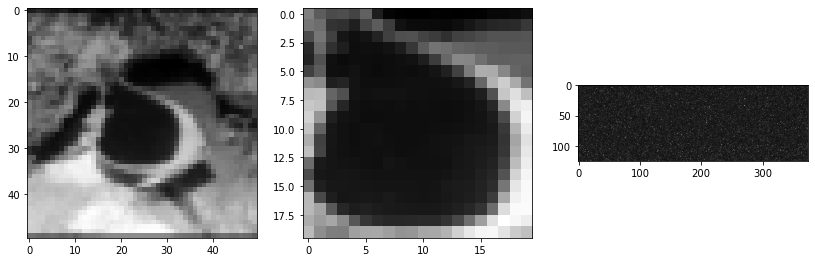

In [8]:
### show data
stim, resp, coords, ori = next(iter(dataloaders["v1_data"]["val"]))
print(
    f"{stim.shape=}, {resp.shape=}"
    f"\n{stim.min()=}, {stim.max()=}"
    f"\n{resp.min()=}, {resp.max()=}"
    f"\n{stim.mean()=}, {stim.std()=}"
    f"\n{resp.mean()=}, {resp.std()=}"
    f"\n{coords.shape=}, {ori.shape=}"
    f"\n{coords.min()=}, {coords.max()=}"
    f"\n{ori.min()=}, {ori.max()=}"
)

fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[0].squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop_stim(stim[0]).squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(133)
ax.imshow(resp[0].view(125, 375).squeeze(0).unsqueeze(-1), cmap="gray")

plt.show()

### Synthetic data (different stimuli dataset -> encoder -> neuronal responses)

In [ ]:
resp_mean = torch.from_numpy(np.load(os.path.join(DATA_PATH, "synthetic_data", "responses_mean.npy"))).float()
resp_std = torch.from_numpy(np.load(os.path.join(DATA_PATH, "synthetic_data", "responses_std.npy"))).float()

config["data"]["syn_data"] = {
    "dataset": {
        "stim_transform": transforms.Normalize(
            mean=114.457,
            std=51.356,
        ),
        "resp_transform": csng.utils.Normalize(
            mean=resp_mean,
            std=resp_std,
        ),
    },
    "dataloader": {
        "batch_size": 20,
        "shuffle": True,
    }
}

In [ ]:
syn_datasets = {
    "train": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data", "processed", "train"),
        **config["data"]["syn_data"]["dataset"]
    ),
    "val": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data", "processed", "val"),
        **config["data"]["syn_data"]["dataset"]
    ),
    "test": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data", "processed", "test"),
        **config["data"]["syn_data"]["dataset"]
    ),
}

dataloaders["syn_data"] = {
    "train": DataLoader(
        dataset=syn_datasets["train"],
        **config["data"]["syn_data"]["dataloader"],
    ),
    "val": DataLoader(
        dataset=syn_datasets["val"],
        **config["data"]["syn_data"]["dataloader"],
    ),
    "test": DataLoader(
        dataset=syn_datasets["test"],
        **config["data"]["syn_data"]["dataloader"],
    ),
}

In [ ]:
### calculate statistics

### for stimuli
# syn_stats = get_mean_and_std(dataset=syn_dataset, verbose=True)
# syn_stats

### for responses
# from csng.utils import RunningStats

# stats = RunningStats(num_components=10000, lib="torch", device="cuda")
# for i, (s, r) in enumerate(syn_dataloader):
#     stats.update(r)
#     if i % 200 == 0:
#         print(f"{i}: {r.mean()=} {r.std()=} {stats.get_mean()=} {stats.get_std()=}")

### save
# torch.save(stats.get_mean(), os.path.join(DATA_PATH, "responses_mean_from_syn_dataset.pt"))
# torch.save(stats.get_std(), os.path.join(DATA_PATH, "responses_std_from_syn_dataset.pt"))


### generate preprocessed synthetic data
# import pickle
# target_dir = os.path.join(DATA_PATH, "synthetic_data", "processed")

# for data_split in ("train", "val", "test"):
#     print(data_split)
#     ### get the whole batch from dataloaders and save to disk
#     sample_idx = 0
#     for stim, resp in syn_dataloaders[data_split]:
#         if sample_idx % 2000 == 0:
#             print("  ", sample_idx)
        
#         for i in range(stim.shape[0]):
#             sample_idx += 1
#             save_to = os.path.join(target_dir, data_split, f"{sample_idx}.pickle")

#             data = {"stim": stim[i].cpu(), "resp": resp[i].cpu()}
#             with open(save_to, "wb") as f:
#                 pickle.dump(data, f)

In [ ]:
### show data
syn_stim, syn_resp = next(iter(dataloaders["syn_data"]["val"]))
print(
    f"{syn_stim.shape=}, {syn_resp.shape=}"
    f"\n{syn_stim.min()=}, {syn_stim.max()=}"
    f"\n{syn_resp.min()=}, {syn_resp.max()=}"
    f"\n{syn_stim.mean()=}, {syn_stim.std()=}"
    f"\n{syn_resp.mean()=}, {syn_resp.std()=}"
)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(131)
ax.imshow(syn_stim.cpu()[0].squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop_stim(syn_stim.cpu()[0]).squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(133)
ax.imshow(syn_resp.cpu()[0].view(100, 100).squeeze(0).unsqueeze(-1), cmap="gray")

plt.show()

### Synthetic data (V1 data stimuli -> encoder -> neuronal responses)

In [ ]:
### load
resp_mean = torch.from_numpy(np.load(os.path.join(DATA_PATH, "synthetic_data_v1_encoder", "responses_mean_original.npy"))).float()
resp_std = torch.from_numpy(np.load(os.path.join(DATA_PATH, "synthetic_data_v1_encoder", "responses_std_original.npy"))).float()

config["data"]["syn_data_v1_enc"] = {
    "dataset": {
        "stim_transform": transforms.Normalize(
            mean=0,
            std=1,
        ),
        "resp_transform": csng.utils.Normalize(
            mean=resp_mean,
            std=resp_std,
        ),
    },
    "dataloader": {
        "batch_size": 30,
        "shuffle": True,
    }
}

In [ ]:
syn_datasets_v1_encoder = {
    "train": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data_v1_encoder", "train"),
        **config["data"]["syn_data_v1_enc"]["dataset"]
    ),
    "val": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data_v1_encoder", "val"),
        **config["data"]["syn_data_v1_enc"]["dataset"]
    ),
    "test": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data_v1_encoder", "test"),
        **config["data"]["syn_data_v1_enc"]["dataset"]
    ),
}

dataloaders["syn_data_v1_enc"] = {
    "train": DataLoader(
        dataset=syn_datasets_v1_encoder["train"],
        **config["data"]["syn_data_v1_enc"]["dataloader"],
    ),
    "val": DataLoader(
        dataset=syn_datasets_v1_encoder["val"],
        **config["data"]["syn_data_v1_enc"]["dataloader"],
    ),
    "test": DataLoader(
        dataset=syn_datasets_v1_encoder["test"],
        **config["data"]["syn_data_v1_enc"]["dataloader"],
    ),
}

In [ ]:
### show data
syn_stim_v1_enc, syn_resp_v1_enc = next(iter(dataloaders["syn_data_v1_enc"]["val"]))
print(
    f"{syn_stim_v1_enc.shape=}, {syn_resp_v1_enc.shape=}"
    f"\n{syn_stim_v1_enc.min()=}, {syn_stim_v1_enc.max()=}"
    f"\n{syn_resp_v1_enc.min()=}, {syn_resp_v1_enc.max()=}"
    f"\n{syn_stim_v1_enc.mean()=}, {syn_stim_v1_enc.std()=}"
    f"\n{syn_resp_v1_enc.mean()=}, {syn_resp_v1_enc.std()=}"
)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(131)
ax.imshow(syn_stim_v1_enc.cpu()[0].squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop_stim(syn_stim_v1_enc.cpu()[0]).squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(133)
ax.imshow(syn_resp_v1_enc.cpu()[0].view(100, 100).squeeze(0).unsqueeze(-1), cmap="gray")

plt.show()

## Decoder

In [9]:
def train(model, dataloader, opter, loss_fn, config, l1_reg_mul=0, l2_reg_mul=0, verbose=True):
    model.train()
    train_loss = 0
    n_batches = len(dataloader)
    
    ### run
    for batch_idx, (stim, resp, coords, ori) in enumerate(dataloader):
        ### data
        stim = stim.to(config["device"])
        resp = resp.to(config["device"])
        
        ### train
        opter.zero_grad()
        stim_pred = model(resp)
        loss = loss_fn(stim_pred, stim)

        ### regularization
        if l1_reg_mul != 0:
            l1_reg = sum(p.abs().sum() for n, p in model.named_parameters() if p.requires_grad and "weight" in n)
            loss += l1_reg_mul * l1_reg
        if l2_reg_mul != 0:
            l2_reg = sum(p.pow(2.0).sum() for n, p in model.named_parameters() if p.requires_grad and "weight" in n)
            loss += l2_reg_mul * l2_reg

        loss.backward()
        opter.step()
        
        ### log
        train_loss += loss.item()
        if verbose and batch_idx % 100 == 0:
            print(f"Training progress: [{batch_idx}/{n_batches} ({100. * batch_idx / n_batches:.0f}%)]"
                  f"  Loss: {loss.item():.6f}")
        batch_idx += 1

    train_loss /= n_batches
    return train_loss

In [10]:
def val(model, dataloader, loss_fn, config):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (stim, resp, coords, ori) in enumerate(dataloader):
            stim = stim.to(config["device"])
            resp = resp.to(config["device"])
            
            stim_pred = model(resp)
            loss = loss_fn(stim_pred, stim)
            
            ### log
            val_loss += loss.item()
    
    val_loss /= len(dataloader)
    return val_loss

In [11]:
def get_dataloaders(config, dataloaders, use_data_names, only_v1_data_eval=True):
    if only_v1_data_eval:
        val_dataloader = dataloaders["v1_data"]["val"]

    ### get dataloaders to mix
    dataloaders_to_mix = []
    for data_name in use_data_names:
        dataloaders_to_mix.append(dataloaders[data_name])

    if len(dataloaders_to_mix) > 1:
        train_dataloader = MixedBatchLoader(
            dataloaders=[dl["train"] for dl in dataloaders_to_mix],
            mixing_strategy=config["data"]["mixing_strategy"],
            device=config["device"],
        )
        if not only_v1_data_eval:
            val_dataloader = MixedBatchLoader(
                dataloaders=[dl["val"] for dl in dataloaders_to_mix],
                mixing_strategy=config["data"]["mixing_strategy"],
                device=config["device"],
            )
    elif len(dataloaders_to_mix) == 1:
        train_dataloader = dataloaders_to_mix[0]["train"]
        if not only_v1_data_eval:
            val_dataloader = dataloaders_to_mix[0]["val"]
    else:
        raise ValueError("No data to train on.")

    return train_dataloader, val_dataloader

In [12]:
config["decoder"] = {
    "model": {
        "resp_shape": (resp.shape[-1],),
        "stim_shape": (1, 50, 50),
        "layers": [
            # ("fc", 256),  # CNN small
            # ("unflatten", 1, (4, 8, 8)),  # CNN small
            # ("deconv", 64, 5, 2, 0),  # CNN small
            # ("deconv", 32, 5, 2, 0),  # CNN small
            # ("deconv", 32, 4, 1, 0),  # CNN small
            
            ("fc", 384),  # CNN Baseline
            ("unflatten", 1, (6, 8, 8)),  # CNN Baseline
            # # ("fc", 512),  # CNN Baseline large
            # # ("unflatten", 1, (8, 8, 8)),  # CNN Baseline large
            ("deconv", 256, 7, 2, 0),
            ("deconv", 64, 5, 2, 0),
            ("deconv", 32, 4, 1, 0),  # CNN Baseline
            # # ("deconv", 64, 5, 1, 1),  # CNN Baseline large
            # # ("deconv", 32, 4, 1, 1),  # CNN Baseline large
            ("deconv", 1, 3, 1, 0),


            ### G from GAN
            # ("fc", 637),
            # ("unflatten", 1, (13, 7, 7)),
            # ("deconv", 256, 7, 2, 0),
            # ("deconv", 128, 5, 2, 0),
            # ("deconv", 64, 5, 1, 0),
            # ("deconv", 64, 4, 1, 0),
            # ("deconv", 1, 3, 1, 0),
        ],
        "act_fn": nn.LeakyReLU,
        "out_act_fn": nn.Identity,
        "dropout": 0.15,
        "batch_norm": True,
    },
    "opter_cls": torch.optim.Adam,
    "opter_kwargs": {
        # "lr": 0.001,
        "lr": 3e-4,
    },
    # "loss_fn": nn.MSELoss(),
    # "loss_fn": MSELossWithCrop(window=config["stim_crop_win"]),
    "loss_fn": SSIMLoss(
        window=config["stim_crop_win"],
        log_loss=True,
        inp_normalized=True,
        size_average=True,
    ),
    "l1_reg_mul": 0,
    "l2_reg_mul": 5e-5,
    "n_epochs": 150,
    "save_run": True,
    "load_ckpt_name": None,
}

decoder = CNN_Decoder(**config["decoder"]["model"]).to(config["device"])
opter = config["decoder"]["opter_cls"](decoder.parameters(), **config["decoder"]["opter_kwargs"])
loss_fn = config["decoder"]["loss_fn"]() if type(config["decoder"]["loss_fn"]) == type else config["decoder"]["loss_fn"]

In [13]:
### prepare checkpointing
if config["decoder"]["save_run"]:
    ### save config
    run_name = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    config["dir"] = os.path.join(DATA_PATH, "models", run_name)
    os.makedirs(config["dir"], exist_ok=True)
    with open(os.path.join(config["dir"], "config.json"), "w") as f:
        json.dump(config, f, indent=4, default=str)
    os.makedirs(os.path.join(config["dir"], "samples"), exist_ok=True)
    os.makedirs(os.path.join(config["dir"], "ckpt"), exist_ok=True)
    make_sample_path = lambda epoch, prefix: os.path.join(
        config["dir"], "samples", f"{prefix}stim_comparison_{epoch}e.png"
    )

    print(f"Run name: {run_name}\nRun dir: {config['dir']}")
else:
    make_sample_path = lambda epoch, prefix: None
    print("WARNING: Not saving the run and the config.")

Run name: 2024-04-03_09-56-08
Run dir: /media/jsobotka/ext_ssd/csng_data/cat_V1_spiking_model/50K_single_trial_dataset/models/2024-04-03_09-56-08


In [14]:
if config["decoder"]["load_ckpt_name"] is not None:
    ### load ckpt
    run_name = config["decoder"]["load_ckpt_name"]  # "2023-08-25_09-07-46"
    ckpt = torch.load(os.path.join(DATA_PATH, "models", run_name, "ckpt", "decoder_40.pt"))

    history = ckpt["history"]
    config = ckpt["config"]
    best = ckpt["best"]

    decoder = CNN_Decoder(**config["decoder"]["model"]).to(config["device"])
    decoder.load_state_dict(ckpt["decoder"])

    opter = config["decoder"]["opter_cls"](decoder.parameters(), **config["decoder"]["opter_kwargs"])
    opter.load_state_dict(ckpt["opter"])

    loss_fn = config["decoder"]["loss_fn"]() if type(config["decoder"]["loss_fn"]) == type else config["decoder"]["loss_fn"]

    make_sample_path = lambda epoch, prefix: os.path.join(
        config["dir"], "samples", f"{prefix}stim_comparison_{epoch}e.png"
    )
else:
    history = {"train_loss": [], "val_loss": []}
    best = {"val_loss": np.inf, "epoch": 0, "model": None}
    make_sample_path = lambda epoch, prefix: None

In [15]:
with torch.no_grad():
    print(decoder(resp.to(config["device"])).shape)
print(f"Number of parameters: {count_parameters(decoder)}")

decoder

torch.Size([64, 1, 50, 50])
Number of parameters: 18520129


CNN_Decoder(
  (layers): Sequential(
    (0): Linear(in_features=46875, out_features=384, bias=True)
    (1): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.15, inplace=False)
    (4): Unflatten(dim=1, unflattened_size=(6, 8, 8))
    (5): ConvTranspose2d(6, 256, kernel_size=(7, 7), stride=(2, 2))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.15, inplace=False)
    (9): ConvTranspose2d(256, 64, kernel_size=(5, 5), stride=(2, 2))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Dropout(p=0.15, inplace=False)
    (13): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(1, 1))
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): LeakyReLU(negative_slope=0.

In [17]:
def plot_losses(history, save_to=None):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(history["train_loss"], label="train")
    ax.plot(history["val_loss"], label="val")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()

    if save_to:
        fig.savefig(save_to)
    ### save fig
    if config["decoder"]["save_run"]:
        fig.savefig(os.path.join(config["dir"], f"losses_{epoch}.png"))

    plt.show()

In [18]:
data_names = list(dataloaders.keys())
print(f"{data_names=}")

data_names=['v1_data']


In [22]:
### train
s, e = len(history["train_loss"]), config["decoder"]["n_epochs"]
for epoch in range(s, e):
    print(f"[{epoch}/{e}]")

    ### train and val
    train_dataloader, val_dataloader = get_dataloaders(
        config=config,
        dataloaders=dataloaders,
        use_data_names=data_names,
        only_v1_data_eval=config["only_v1_data_eval"],
    )
    train_loss = train(
        model=decoder,
        dataloader=train_dataloader,
        opter=opter,
        loss_fn=loss_fn,
        config=config,
        l1_reg_mul=config["decoder"]["l1_reg_mul"],
        l2_reg_mul=config["decoder"]["l2_reg_mul"],
    )
    val_loss = val(
        model=decoder,
        dataloader=val_dataloader,
        loss_fn=loss_fn,
        config=config,
    )

    ### save best model
    if val_loss < best["val_loss"]:
        best["val_loss"] = val_loss
        best["epoch"] = epoch
        best["model"] = deepcopy(decoder.state_dict())

    ### log
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    print(f"{train_loss=:.4f}, {val_loss=:.4f}")

    ### plot reconstructions
    stim_pred = decoder(resp[:8].to(config["device"])).detach()
    if "v1_data" in config["data"] and config["data"]["v1_data"]["crop"] == False:
        plot_comparison(target=crop_stim(stim[:8]).cpu(), pred=crop_stim(stim_pred[:8]).cpu(), save_to=make_sample_path(epoch, ""))
    else:
        plot_comparison(target=stim[:8].cpu(), pred=stim_pred[:8].cpu(), save_to=make_sample_path(epoch, "no_crop_"))

    ### plot losses + save ckpt
    if epoch % 5 == 0 and epoch > 0:
        plot_losses(history=history)

        ### ckpt
        if config["decoder"]["save_run"]:
            torch.save({
                "decoder": decoder.state_dict(),
                "opter": opter.state_dict(),
                "history": history,
                "config": config,
                "best": best,
            }, os.path.join(config["dir"], "ckpt", f"decoder_{epoch}.pt"), pickle_module=dill)

[0/150]
Training progress: [0/703 (0%)]  Loss: 0.697812


In [ ]:
print(f"Best val loss: {best['val_loss']:.4f} at epoch {best['epoch']}")

### save final ckpt
if config["decoder"]["save_run"]:
    torch.save({
        "decoder": decoder.state_dict(),
        "opter": opter.state_dict(),
        "history": history,
        "config": config,
        "best": best,
    }, os.path.join(config["dir"], f"decoder.pt"))

### plot reconstructions of the final model
decoder.load_state_dict(best["model"])
stim_pred_best = decoder(resp.to(config["device"])).detach().cpu()
plot_comparison(
    target=crop_stim(stim[:8]).cpu(),
    pred=crop_stim(stim_pred_best[:8]).cpu(),
    save_to=os.path.join(config["dir"], "stim_comparison_best.png")
)

### plot losses
plot_losses(
    history=history,
    save_to=None if not config["decoder"]["save_run"] else os.path.join(config["dir"], f"losses.png"),
)